### Laboratorium 6 - część projektowa

W tej części zajmiesz się wykorzystaniem punktów kluczowych do łączenia obrazów (_image stitching_). Celem zadania jest przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia obrazów. Istotne jest, by samodzielnie przejść całą ścieżkę: od detekcji punktów kluczowych i wyznaczenia ich desktryptorów, przez ich parowanie i znalezienie transformacji, po finalne połączenie obrazów. Rozwiązania oparte o gotowce w stylu black-box nie będą oceniane.

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być niemal dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy umożliwiały (1) użycie algorytmu SIFT, oraz (2) wykonanie transformacji geometrycznej.

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o ~połowę szerokości klatki),
* większe przesunięcie (o 3/4 szerokości lub więcej),
* przesunięcie z rotacją w osi kamery,
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3b) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary wynikowych obrazów są wystarczające do zmieszczenia obu składowych.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jeśli dla którejś pary metoda zawiodła, to dlaczego?*  
*Jaka była jakość dopasowania? Na jakiej podstawie ją określasz?*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scripts.__init__ import *
from scripts.scripts import scale_img, interactive_matcher, interactive_homography, stitch_images

## Wersja 1

In [3]:
root = 'lab6_zdjecia/zestaw_2'

base = cv2.imread(f'{root}/base.jpg')[..., ::-1]
offset_0 = cv2.imread(f'{root}/offset_0.jpg')[..., ::-1]
offset_1 = cv2.imread(f'{root}/offset_1.jpg')[..., ::-1]
offset_2 = cv2.imread(f'{root}/offset_2.jpg')[..., ::-1]
offset_3 = cv2.imread(f'{root}/offset_3.jpg')[..., ::-1]

In [4]:
base = scale_img(base)
offset_0 = scale_img(offset_0)
offset_1 = scale_img(offset_1)
offset_2 = scale_img(offset_2)
offset_3 = scale_img(offset_3)

In [5]:
interactive_matcher(base, offset_0)

interactive(children=(FloatSlider(value=0.08, description='contrastThreshold', layout=Layout(width='40%'), max…

In [6]:
interactive_homography(offset_0, base)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…

In [7]:
def stitch_images(img1, img2, ct = 0.04, et = 50, d = 0.75, method = cv2.RANSAC, ransac_thresh = 5.0):
    img1 = img1.copy()
    img2 = img2.copy()
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, None)
    kp2, ds2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
    matches = bf.knnMatch(ds1, ds2, k = 2)

    good_matches = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    if method == cv2.RANSAC or method == cv2.RHO:
        H, mask = cv2.findHomography(src_pts, dst_pts, method, ransac_thresh)
    else:
        H, mask = cv2.findHomography(src_pts, dst_pts, method)
        
    
    height1, width1, _ = img1.shape
    height2, width2, _ = img2.shape
    panorama_width = width1 + width2
    panorama_height = max(height1, height2)
    
    transformed_img = cv2.warpPerspective(img1, H, (panorama_width, panorama_height))
    transformed_img[0:height2, 0:width2] = img2
    return transformed_img

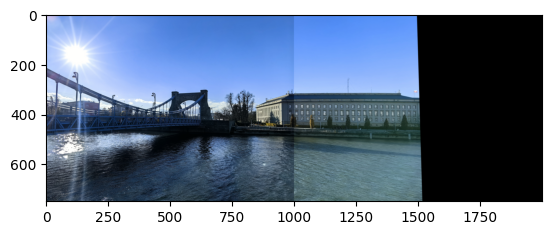

In [8]:
plt.imshow(stitch_images(offset_0, base))

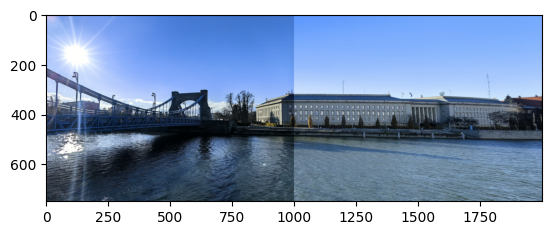

In [9]:
plt.imshow(stitch_images(offset_1, base))

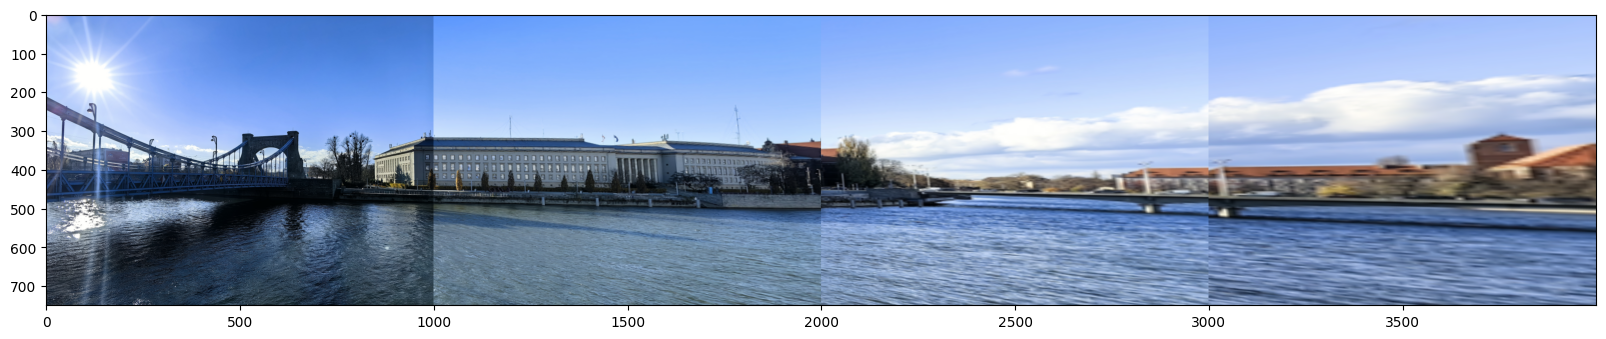

In [10]:
base0 = stitch_images(offset_1, base)
# base1 = stitch_images(offset_1, base0)
base2 = stitch_images(offset_2, base0)
base3 = stitch_images(offset_3, base2)
fig = plt.figure(figsize = (20, 5))
plt.imshow(base3)

## Wersja 2

In [3]:
root = 'lab6_zdjecia/zestaw_3'
photos = [f'{root}/{path}' for path in os.listdir(root)]
photos = [cv2.imread(img)[..., ::-1] for img in photos]
photos = np.array([scale_img(photo) for photo in photos])

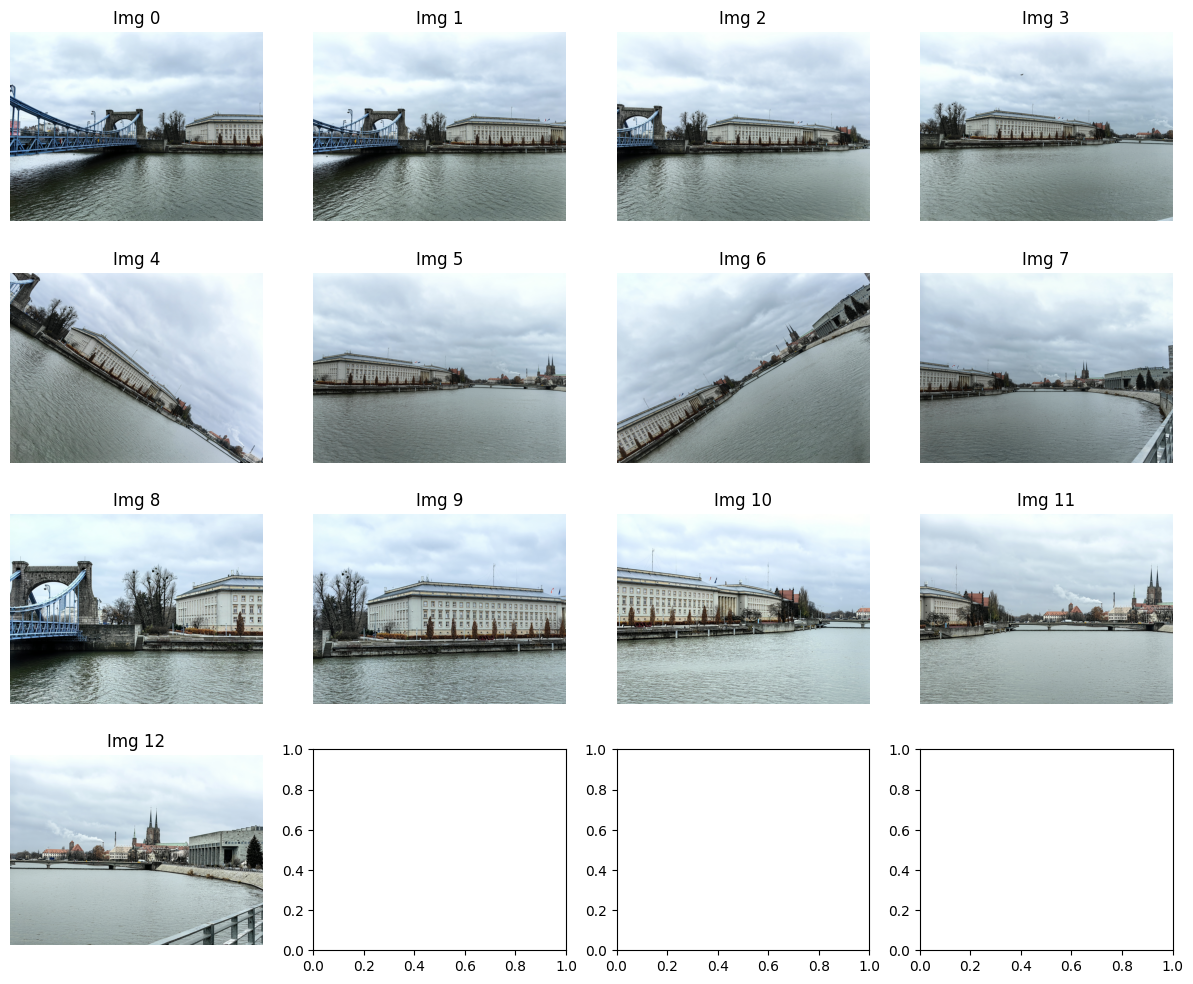

In [4]:
fig, axs = plt.subplots(4, 4, figsize = (15, 12))
for i in range(len(photos)):
    axs[i // 4][i % 4].imshow(photos[i])
    axs[i // 4][i % 4].axis('off')
    axs[i // 4][i % 4].set_title(f'Img {i}')
plt.show()

In [5]:
base = photos[1]
offset_0 = photos[2]
offset_1 = photos[3]
offset_2 = photos[4] # obrócone o kąt
offset_3 = photos[5]
offset_4 = photos[9] # zdjęcie zbliżone

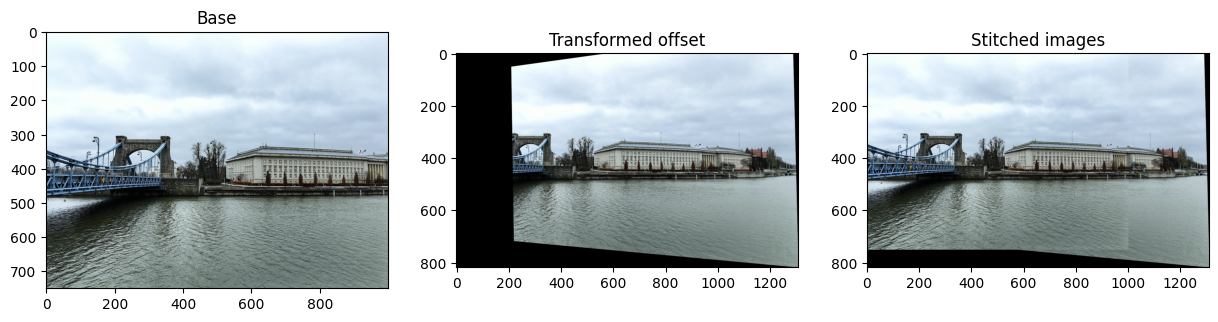

In [6]:
stitch_images(offset_0, base)

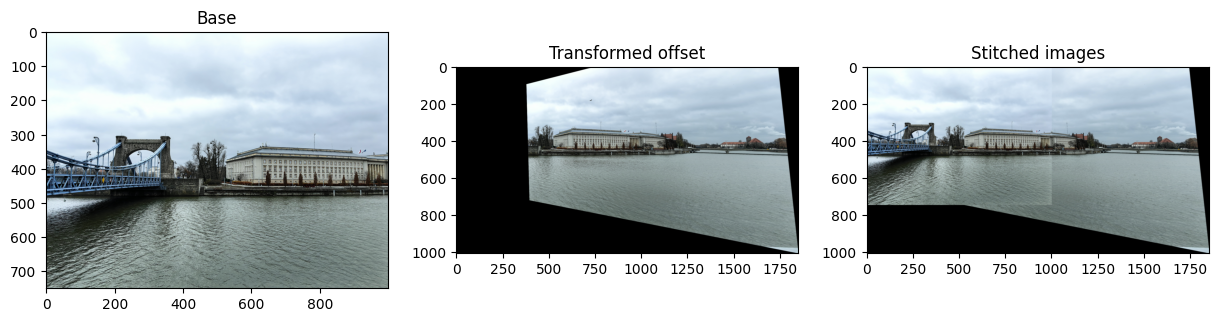

In [7]:
stitch_images(offset_1, base)

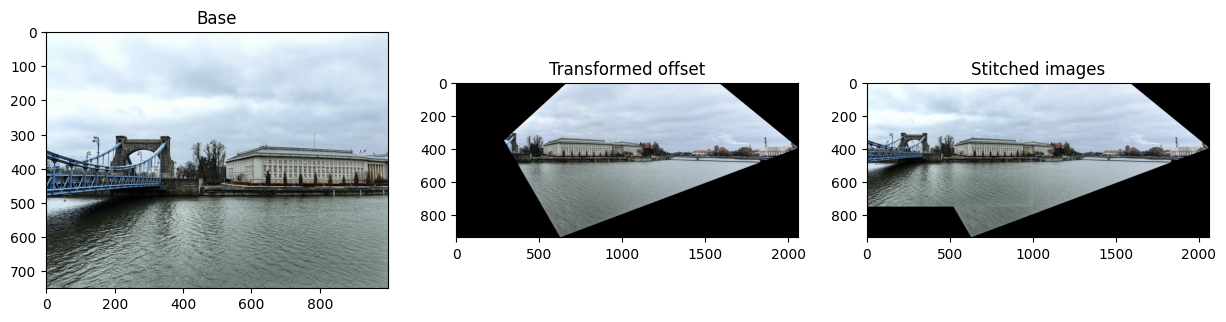

In [8]:
stitch_images(offset_2, base)

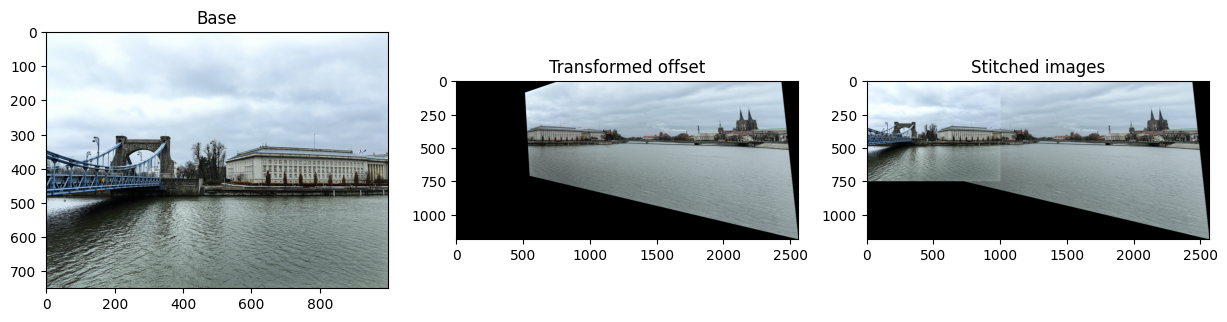

In [9]:
stitch_images(offset_3, base)

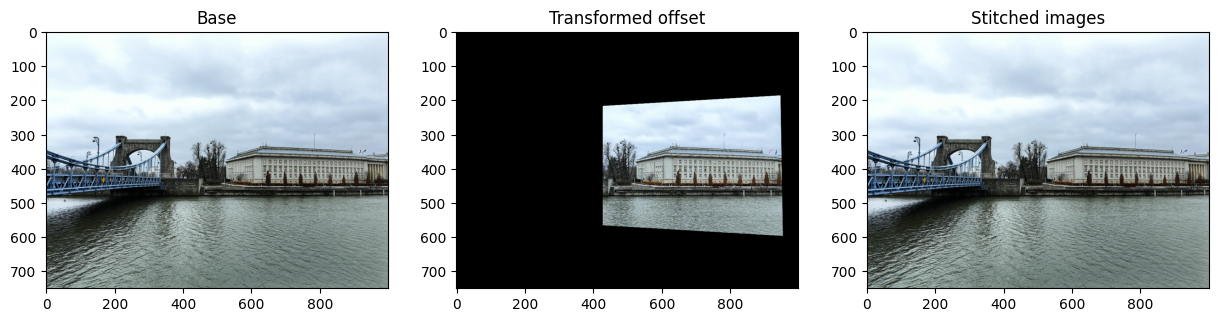

In [10]:
stitch_images(offset_4, base)

In [11]:
interactive_homography(offset_4, base)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…